# Sentiment Analysis of Movie Reviews using TfidfVectorizer and Classifiers from scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using classes available in scikit-learn.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using TfidfVectorizer. Multiple classification models from scikit-learn are trained and tested on the results. The best performing model is pickled for later deployment.

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from datasets import load_dataset
from scipy.stats import loguniform, uniform
from nltk import PorterStemmer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from app.cleaner.preprocessor import Preprocessor
from app.cleaner.tokenizer import Tokenizer

## Load the IMDB Dataset

In [2]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In the following DataFrame samples, a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [3]:
train.sample(5)

,text,label
21944,One thing I always liked about Robert Ludlum t...,1
6801,It's sad when you can see what a movie was att...,0
10049,I wasn't terribly impressed with Dante's 1st s...,0
9538,A text prologue warns us that we should not al...,0
11472,It was obvious that this movie is designed to ...,0


In [4]:
test.sample(5)

,text,label
13744,"conventional and superficial ,Claude´s portray...",1
13427,"This is primarily about love in WWII, yet we m...",1
8739,"A single mom,her son and daughter and their hi...",0
10540,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3775,"Reading the other two comments, I had to wonde...",0


## Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


I plot the distribution of movie review labels in the train set.

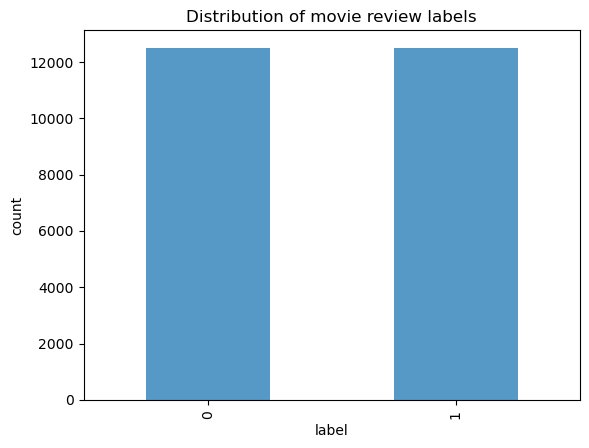

In [6]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of movie review labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [7]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of reviews to better understand what is meant by "highly polarized."

In [8]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [9]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
print('\n\n'.join(thumbs_up_samples))

This wonderful 1983 BBC television production (not a movie, as others have written here) of the classic love story "Jane Eyre", starring Timothy Dalton as Rochester, and Zelah Clarke as Jane, is the finest version that has been made to date, since it is the most faithful to the novel by Charlotte Bronte in both concept and dialogue. <br /><br />A classic becomes a classic for very specific reasons; when film producers start to meddle with a classic's very lifeblood then that classic is destroyed. Thankfully the producers of THIS "Jane Eyre" approached the story with respect and faithfulness towards the original, which results in a spectacularly addictive concoction that is worth viewing multiple times, to enjoy its multi-layers of sweetness and delight and suspense. The performances are delightful, the music is just right, even the Gothic design of the house and outdoor shots are beautiful, and set the right tone for the production. <br /><br />My only criticism, though slight, is that

In [10]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
print('\n\n'.join(thumbs_down_samples))

Incredibly muddled, off-putting and ultimately ludicrous ("the horses, oh my God, the horses!") thriller. It's creepy at times, but it has one of the worst scripts ever written for a horror film. Watch how in the final 10 minutes everybody "magically" does exactly what the plot needs for the "resolution" to occur. Bland performances by the leads, a typically eccentric one by Richard Lynch. The video transfer is a real hack job, cutting scenes in half and making the movie even more difficult to understand. 0 out of 4 stars.

Just saw the movie this past weekend, I am upset, and disappointed with it. Basically, the movie tells you that immigrants, the ones from former Soviet Union especially, come to this country, bring everyone they can with them from the old country, and invade and take over what Americans have been working for. Which is a very wrong way of looking at immigration, and a much worse way of telling people about it. That's the main thing. Another thing, the overall writing

Generally, it is pretty clear from reading a particular review whether it is a thumbs-up or thumbs-down.

## Preprocessor

The preprocessor transforms movie reviews by lower-casing, removing HTML tags, and removing punctuation.

In [11]:
preprocessor = Preprocessor()

To see the preprocessor in action, pick a random movie review:

In [12]:
doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

Jafar Panahi's comedy-drama "Offside" portrays some women trying to enter a Tehran sports arena from which women are banned. The official reason: lots of foul language, and the soccer players have their legs showing. But of course, it's really a case of sexism. So, most of the movie consists of mild comic relief as the women try to ask the men serious questions about why women are banned from the stadium, and one woman even comes up with her own scheme to defy the men.<br /><br />As I understand, all of Jafar Panahi's movies (this one included) are banned in Iran. The real tragedy is that the CIA's 1953 overthrow of the prime minister and subsequent backing of the brutal shah gave Ayatollah Khomeini an excuse to use his narrow interpretation of the Koran to establish a chauvinistic society, and that George W. Bush's current policy towards Iran gives Mahmoud Ahmadinejad an excuse to act the cowboy and tighten censorship.<br /><br />Above all, this is a neat look at people coming up with

## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [13]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

To see the tokenizer in action, transform the previously preprocessed movie review.

In [14]:
doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

jafar panahis comedydrama offside portrays some women trying to enter a tehran sports arena from which women are banned the official reason lots of foul language and the soccer players have their legs showing but of course its really a case of sexism so most of the movie consists of mild comic relief as the women try to ask the men serious questions about why women are banned from the stadium and one woman even comes up with her own scheme to defy the men  as i understand all of jafar panahis movies this one included are banned in iran the real tragedy is that the cias 1953 overthrow of the prime minister and subsequent backing of the brutal shah gave ayatollah khomeini an excuse to use his narrow interpretation of the koran to establish a chauvinistic society and that george w bushs current policy towards iran gives mahmoud ahmadinejad an excuse to act the cowboy and tighten censorship  above all this is a neat look at people coming up with ways to challenge the system not a great mov

## Vectorizer

I use the `TfidfVectorizer` to map documents to vectors.

In [15]:
vectorizer = TfidfVectorizer(
    max_df = 0.95,
    min_df = 2,
    max_features = 10_000,
    strip_accents='unicode'
)

cleaner = Pipeline([
    ('preprocessor', preprocessor),
    ('tokenizer', tokenizer),
    ('vectorizer', vectorizer)
])

## Classifers

I train and test logistic regression, random forest, and support vector machine classifiers on the IMDB movie reviews. I score the models using F1-score because the train set is balanced and the consequences of misclassifying a positive review are the same as misclassifying a negative review.

In [16]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

### Logistic Regression

In [17]:
lr = LogisticRegression(
    penalty='l2',
    max_iter=1000
)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', lr)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__solver': ['liblinear', 'newton-cholesky', 'saga']
}

search_lr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [18]:
search_lr.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END classifier__C=2.052745531276983, classifier__solver=saga; total time=  41.9s
[CV] END classifier__C=2.052745531276983, classifier__solver=saga; total time=  40.6s
[CV] END classifier__C=2.052745531276983, classifier__solver=saga; total time=  41.8s
[CV] END classifier__C=2.052745531276983, classifier__solver=saga; total time=  41.7s
[CV] END classifier__C=2.052745531276983, classifier__solver=saga; total time=  42.7s
[CV] END classifier__C=0.015118728475747849, classifier__solver=newton-cholesky; total time= 1.3min
[CV] END classifier__C=0.015118728475747849, classifier__solver=newton-cholesky; total time= 1.1min
[CV] END classifier__C=0.015118728475747849, classifier__solver=newton-cholesky; total time= 1.1min
[CV] END classifier__C=0.015118728475747849, classifier__solver=newton-cholesky; total time= 1.1min
[CV] END classifier__C=0.015118728475747849, classifier__solver=newton-cholesky; total time= 1.1min
[CV] END 

In [19]:
test_score_lr = search_lr.score(X_test, y_test)

print(f'Best parameters: {search_lr.best_params_}')
print(f'Test F1-score: {test_score_lr}')

Best parameters: {'classifier__C': 0.9047182522681312, 'classifier__solver': 'liblinear'}
Test F1-score: 0.8745307882756969


In [20]:
best_model = search_lr.best_estimator_
best_score = test_score_lr

### Random Forest

In [21]:
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', rfc)
])

param_distributions = {
    'classifier__n_estimators': [10, 30, 100, 300, 1000],
    'classifier__max_depth': list(range(10, 101)),
    'classifier__min_samples_split': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(1, 11))
}

search_rfc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [22]:
search_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__max_depth=38, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=30; total time=  41.1s
[CV] END classifier__max_depth=38, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=30; total time=  40.7s
[CV] END classifier__max_depth=38, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=30; total time=  39.9s
[CV] END classifier__max_depth=38, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=30; total time=  39.9s
[CV] END classifier__max_depth=38, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=30; total time=  40.1s
[CV] END classifier__max_depth=66, classifier__min_samples_leaf=10, classifier__min_samples_split=6, classifier__n_estimators=300; total time= 1.0min
[CV] END classifier__max_depth=66, classifier__m

In [23]:
test_score_rfc = search_rfc.score(X_test, y_test)

print(f'Best parameters: {search_rfc.best_params_}')
print(f'Test F1-score: {test_score_rfc}')

Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 65}
Test F1-score: 0.8527169114696204


In [24]:
if test_score_rfc > best_score:
    best_model = search_rfc.best_estimator_
    best_score = test_score_rfc

### Support Vector Machine

In [25]:
svc = LinearSVC(penalty='l2', dual='auto', max_iter=2500)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', svc)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__loss': ['hinge', 'squared_hinge']
}

search_svc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=2
)

In [26]:
search_svc.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__C=0.045334189165323176, classifier__loss=hinge; total time=  37.7s
[CV] END classifier__C=0.045334189165323176, classifier__loss=hinge; total time=  37.6s
[CV] END classifier__C=0.045334189165323176, classifier__loss=hinge; total time=  37.6s
[CV] END classifier__C=0.045334189165323176, classifier__loss=hinge; total time=  37.8s
[CV] END classifier__C=0.045334189165323176, classifier__loss=hinge; total time=  37.9s
[CV] END classifier__C=0.08001146197978674, classifier__loss=hinge; total time=  37.0s
[CV] END classifier__C=0.08001146197978674, classifier__loss=hinge; total time=  36.8s
[CV] END classifier__C=0.08001146197978674, classifier__loss=hinge; total time=  37.0s
[CV] END classifier__C=0.08001146197978674, classifier__loss=hinge; total time=  37.3s
[CV] END classifier__C=0.08001146197978674, classifier__loss=hinge; total time=  37.2s
[CV] END classifier__C=7.879184428589597, classifier__loss=hinge

In [27]:
test_score_svc = search_svc.score(X_test, y_test)

print(f'Best model: {search_svc.best_params_}')
print(f'Test F1-score: {test_score_svc}')

Best model: {'classifier__C': 0.25921923662849167, 'classifier__loss': 'hinge'}
Test F1-score: 0.8752683043167183


In [28]:
if test_score_svc > best_score:
    best_model = search_svc.best_estimator_
    best_score = test_score_svc

## Conclusion

In [29]:
print(f'Test F1-scores:')
print(f'    Logistic regression: {test_score_lr}')
print(f'    Random forest: {test_score_rfc}')
print(f'    Support vector machine: {test_score_svc}')

Test F1-scores:
    Logistic regression: 0.8745307882756969
    Random forest: 0.8527169114696204
    Support vector machine: 0.8752683043167183


I pickle the best-performing model so that it can be deployed later.

In [30]:
model_dir = 'app/model'
with open(f'{model_dir}/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)